# [集成学习](https://www.cnblogs.com/jasonfreak/p/5657196.html)
* 目的：前面介绍了一系列的算法，每个算法有不同的适用范围，例如有处理线性可分问题的，有处理线性不可分问题。在现实世界的生活中，常常会因为“集体智慧”使得问题被很容易解决，那么问题来了，在机器学习问题中，对于一个复杂的任务来说，能否将很多的机器学习算法组合在一起，这样计算出来的结果会不会比使用单一的算法性能更好？这样的思路就是集成学习方法。

* 集成学习的基本结构为：先产生一组个体学习器，再使用某种策略将它们结合在一起。集成模型如下图所示：
![](./img/3.png)
在上图的集成模型中，若个体学习器都属于同一类别，例如都是决策树或都是神经网络，则称该集成为同质的（homogeneous）;若个体学习器包含多种类型的学习算法，例如既有决策树又有神经网络，则称该集成为异质的（heterogenous）。
1. 同质集成：个体学习器称为“基学习器”（base learner），对应的学习算法为“基学习算法”（base learning algorithm）。 
1. 异质集成：个体学习器称为“组件学习器”（component learner）或直称为“个体学习器”。

* 一般经验中，如果把好坏不等的东西掺到一起结果通常会比最坏的要好一些，比最好的要坏一些，如何获得更好的性能呢？
![](./img/1.png)
由图上可以看出：集成学习需要准确性和多样性（diversity）。准确性指的是个体学习器不能太差，要有一定的准确度；多样性则是个体学习器之间的输出要具有差异性。通过上面的这三个例子可以很容易看出这一点，准确度较高，差异度也较高，可以较好地提升集成性能。

## Boosting
* Boosting的思路则是采用重赋权（re-weighting）法迭代地训练基分类器，即对每一轮的训练数据样本赋予一个权重，并且每一轮样本的权值分布依赖上一轮的分类结果；基分类器之间采用序列式的线性加权方式进行组合。
![](./img/2.png)
* 典型代表：AdaBoost， Xgboost，GBDT(不讲了)
* 最终的结果：每个分类器根据自身的准确性来确定各自的权重，再合体
* 从偏差-方差的角度来看：主要关注**降低偏差**

### [AdaBoost](https://blog.csdn.net/guyuealian/article/details/70995333)
* AdaBoost是英文"Adaptive Boosting"（自适应增强）的缩写，它的自适应在于：前一个基本分类器被错误分类的样本的权值会增大，而正确分类的样本的权值会减小，并再次用来训练下一个基本分类器。同时，在每一轮迭代中，加入一个新的弱分类器，直到达到某个预定的足够小的错误率或达到预先指定的最大迭代次数才确定最终的强分类器。

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
iris = load_iris()
clf = AdaBoostClassifier(n_estimators=100)#默认的基学习器是决策树，可以选择其他的如SVM、LR等等
scores = cross_val_score(clf, iris.data, iris.target)
scores.mean() 

0.9599673202614379

### [Xgboost](https://blog.csdn.net/a819825294/article/details/51206410)
* 用一个保险赔偿预测例子来使用Xgboost

* 数据说明：保险赔偿预测
![](./img/4.png)

In [13]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

* 数据预处理

In [14]:
train = pd.read_csv('./data/train.csv')
train.head()
#132个属性，包括ID和赔偿

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [20]:
print(train.shape)
print(train.columns)

(188318, 133)
Index(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'cont14', 'loss', 'log_loss'],
      dtype='object', length=133)


对loss做对数转换（因为赔偿差距很大，对数化使其更加聚集）

In [17]:
train['log_loss'] = np.log(train['loss'])

数据分成连续和离散特征

In [18]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]#所有特征

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]#从类型为object的属性中找到所有特征
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]#类型不是object的属性中找到所有特征

print ("Categorical features:", len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 116
Numerical features: 14


In [19]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes#将其转换为数字形式
    
print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


In [22]:
train_x.head(2)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496


* 简单Xgboost

首先，我们训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差来衡量

mean_absolute_error(np.exp(y), np.exp(yhat))。


xgboost 自定义了一个数据矩阵类 DMatrix，会在训练开始时进行一遍预处理，从而提高之后每次迭代的效率

In [23]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

In [24]:
dtrain = xgb.DMatrix(train_x, train['log_loss'])

#### Xgboost参数
- 'booster':'gbtree',
- 'objective': 'multi:softmax', 多分类的问题
- 'num_class':10, 类别数，与 multisoftmax 并用
- 'gamma':损失下降多少才进行分裂
- 'max_depth':12, 构建树的深度，越大越容易过拟合
- 'lambda':2,  控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
- 'subsample':0.7, 随机采样训练样本
- 'colsample_bytree':0.7, 生成树时进行的列采样
- 'min_child_weight':3, 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束
- 'silent':0 ,设置成1则没有运行信息输出，最好是设置为0.
- 'eta': 0.007, 如同学习率
- 'seed':1000,
- 'nthread':7, cpu 线程数

In [25]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

使用交叉验证

In [26]:
%%time
bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 1219.5729979999999
Wall time: 56.1 s


我们得到了第一个基准结果：MAE＝1219.57

In [31]:
bst_cv1.head(2)#Dataframe格式

,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
0,3033.941244,17.079337,3033.941406,8.538825
1,3030.846191,17.081012,3030.846273,8.535260


<Figure size 432x288 with 0 Axes>

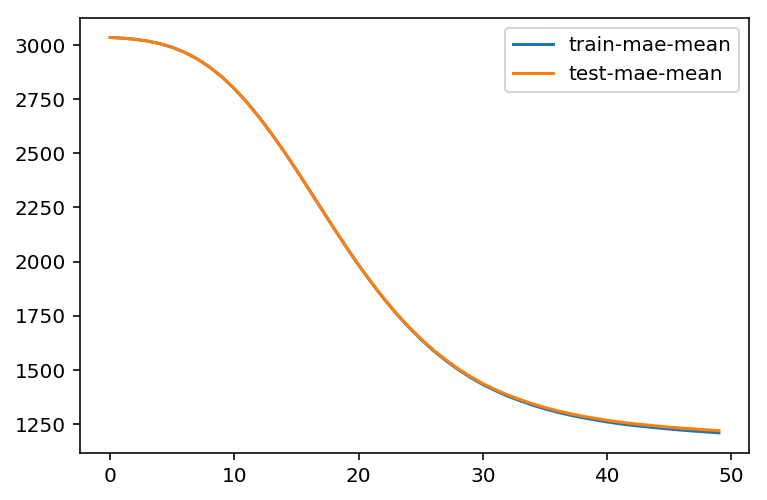

In [33]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

## Bagging
训练多个分类器，取平均。从训练集从进行子抽样组成每个基模型所需要的子训练集，对所有基模型预测的结果进行综合产生最终的预测结果：
![](./img/1.jpg)
* 代表算法：随机森林
* 从偏差-方差分解的角度看，Bagging主要关注**降低方差**，因此它在不减枝决策树、神经网络等易受样本扰动的学习器上效果更为明显。

### RandomForest
* 二重随机性：数据采样随机，特征选择随机
* 随机森林优势：
    1. 它能够处理很高维度（feature很多）的数据，并且不用做特征选择
    1. 在训练完后，它能够给出哪些feature比较重要
    1. 容易做成并行化方法，速度比较快
    1. 可以进行可视化展示，便于分析

#### Example:泰坦尼克获救预测

In [26]:
import pandas as pd #ipython notebook
titanic = pd.read_csv("./data/titanic_train.csv")
titanic.head(2)
#print (titanic.describe())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [27]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())#缺失值补充中位数
print(titanic.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.361582    0.523008   
std     257.353842    0.486592    0.836071   13.019697    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [28]:
print(titanic["Sex"].unique())
# Replace all the occurences of male with the number 0.
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

['male' 'female']


In [29]:
print(titanic["Embarked"].unique())
titanic["Embarked"] = titanic["Embarked"].fillna('S')
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

['S' 'C' 'Q' nan]


In [30]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.model_selection import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class
alg = LinearRegression()
# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold( n_splits=3, random_state=1)

predictions = []
for train_index, test_index in kf.split(titanic):
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train_index,:])
    # The target we're using to train the algorithm.
    train_target = titanic["Survived"].iloc[train_index]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test_index,:])
    predictions.append(test_predictions)


In [31]:
import numpy as np

# The predictions are in three separate numpy arrays.  Concatenate them into one.  
# We concatenate them on axis 0, as they only have one axis.
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.2615039281705948


In [32]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = model_selection.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.7878787878787877


In [33]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0


In [34]:
#简单随机森林
from sklearn.ensemble import RandomForestClassifier

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = model_selection.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.7856341189674523


In [35]:
# 选模型&参数调优
alg = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = model_selection.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.8148148148148148


* 特征选择

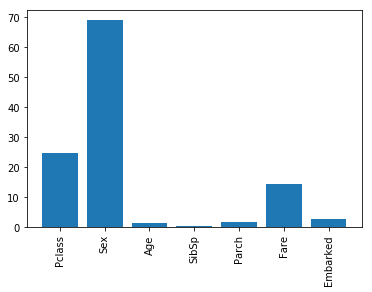

In [36]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
% matplotlib inline


# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

## [Stacking](https://blog.csdn.net/willduan1/article/details/73618677)
* 聚合多个分类或回归模型（可以分阶段来做）:
![](./img/2.jpg)

* 堆叠：很暴力，拿来一堆直接上（各种分类器都来了）
* 可以堆叠各种各样的分类器（KNN,SVM,RF等等）
* 分阶段：第一阶段得出各自结果，第二阶段再用前一阶段结果训练
* 为了刷结果，不择手段！

1. 最基本的使用方法，即使用前面分类器产生的特征输出作为最后总的meta-classifier的输入数据

In [1]:
from sklearn import datasets  
  
iris = datasets.load_iris()  
X, y = iris.data[:, 1:3], iris.target  
  
from sklearn import model_selection  
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB   
from sklearn.ensemble import RandomForestClassifier  
from mlxtend.classifier import StackingClassifier  
import numpy as np  
  
clf1 = KNeighborsClassifier(n_neighbors=1)  
clf2 = RandomForestClassifier(random_state=1)  
clf3 = GaussianNB()  
lr = LogisticRegression()  
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],   
                          meta_classifier=lr)  
  
print('3-fold cross validation:\n')  
  
for clf, label in zip([clf1, clf2, clf3, sclf],   
                      ['KNN',   
                       'Random Forest',   
                       'Naive Bayes',  
                       'StackingClassifier']):  
  
    scores = model_selection.cross_val_score(clf, X, y,   
                                              cv=3, scoring='accuracy')  
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"   
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.03) [StackingClassifier]
